Se realiza el Análisis Exploratorio de los Datos de los tres archivos de datos ya limpios para finalmente elegir las variables que serán usadas para entrenar el modelo de recomendación solicitado. Esto se hace teniendo en cuenta el gran volumen de información y los recursos de procesamiento y almacenamiento, sobretodo al momento de deployar el proyecto, los cuales son limitados.

In [1]:
import pandas as pd             # importo modulo panda Data Analysis Library
import matplotlib.pyplot as plt # importo modulo pyplot de Matplotlib Library
import seaborn as sns           # importo modulo seaborn
import warnings                 # importo modulo warnings - Ignore all warnings
warnings.filterwarnings("ignore")

EDA del dataset  `df_user_reviews`

En esta sección se desarrolla el Análisis Exploratorio de los Datos del archivo `df_user_reviews` que ya pasó por el proceso de ETL.

Se leen los datos de .csv y se guarda en un dataframe.

In [2]:
df_review = pd.read_csv('Datos/df_user_reviews.csv', encoding='utf-8')
df_review.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Datos/df_user_reviews.csv'

Se calcula la cantidad de registros

In [ ]:
print(f'La cantidad de registros que hay son: {df_review.shape[0]}')
def obtener_informacion_columnas(df):
    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].dtype)
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100 - porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    return df_info
informacion_columnas = obtener_informacion_columnas(df_review)
print(informacion_columnas)

La cantidad de registros que hay son: 57367
         nombre_campo tipo_datos  no_nulos_%  nulos_%  nulos
0             user_id     object       100.0      0.0      0
1            user_url     object       100.0      0.0      0
2     reviews_item_id      int64       100.0      0.0      0
3     reviews_helpful     object       100.0      0.0      0
4   reviews_recommend       bool       100.0      0.0      0
5      reviews_review     object       100.0      0.0      0
6        reviews_date     object       100.0      0.0      0
7  sentiment_analysis      int64       100.0      0.0      0


Se tienen 58431 registros de opiniones de los usuarios respecto a los juegos que consumen.

COLUMNAS 'SENTIMENT_ANALYSIS' Y 'REVIEWS_RECOMMEND'

Se exploran las columnas 'Sentiment_analysis' y 'Reviews_recommend'.

In [ ]:
def cant_porcentaje(df, columna):
    # Cuanta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    porcentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": porcentages
    })
    return df_results
cant_porcentaje(df_review, 'sentiment_analysis')

,Cantidad,Porcentaje
sentiment_analysis,,
1,35241,61.43
2,17100,29.81
0,5026,8.76


In [ ]:
def cant_porcentaje(df, columna):
    # Cuanta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    porcentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": porcentages
    })
    return df_results
cant_porcentaje(df_review, 'reviews_recommend')

,Cantidad,Porcentaje
reviews_recommend,,
True,50751,88.47
False,6616,11.53


De los registros de reviews casi el 62%  de los reviews reflejan sentimientos neutrales,  casi el 30% reflejan sentimientos positivos hacia el juego y menos del 9% fue negativo. Pero en el 88% de los reviews se recomiendan los juegos que consumen.

En el siguiente código se busca ver la cantidad de recomendaciones para los distintos sentimientos de las reviews.

In [ ]:
# Se agrupa por 'sentiment_analysis' y 'reviews_recommend'
df_agrupado = df_review.groupby(['sentiment_analysis', 'reviews_recommend'])
# Se cuentan la cantidad de reviews en cada grupo
cantidad_grupo = df_agrupado.size()
# Se calcula el porcentaje por cada grupo
porcentaje_grupo = 100 * df_agrupado.size() / len(df_review)
# Se crea un datafram con el resumen
sentimiento_recomendacion = pd.DataFrame({
    "Cantidad": cantidad_grupo,
    "Porcentaje": porcentaje_grupo
})
sentimiento_recomendacion

Cantidad  Porcentaje
sentiment_analysis reviews_recommend                      
0                  False                  1652    2.879704
                   True                   3374    5.881430
1                  False                  4367    7.612390
                   True                  30874   53.818397
2                  False                   597    1.040668
                   True                  16503   28.767410

Se puede ver que el porcentaje respecto del total de los reviews que casi el 54% de los reviews que reflejan un sentimiento neutral recomienda el juego por lo que un sentimiento neutral podría estar relacionado con un comentario sencillo sin muchos detalles pero que aún así el juego le gustó como para recomendar. Por otra parte, de los comentarios que reflejaron un sentimiento negativo cerca del 6% aún recomienda el juego, lo que es algo contradictorio.

In [ ]:
# Cantidad de usuarios que dieron su opinion
print(f"Cantidad de usuarios únicos que opinaron: {len(df_review['user_id'].unique())}")

Cantidad de usuarios únicos que opinaron: 25132


Un total de 25143 usurarios dieron su opinión sobre el juego que consumen, con lo que un usuario hizo mas de un comentario.

Se revisan la cantidad de fechas con formato inválido o que no tenían fecha en el conjunto de datos original de la columna 'Reviews_date'.

In [ ]:
print(f'La cantidad de fechas en formato inválido son: {len(df_review[df_review["reviews_date"]=="Formato inválido"])}')

La cantidad de fechas en formato inválido son: 9768


Hay 9768 registros que no contienen la fecha del review.

En el siguiente gráfico se puede ver la distribución de la cantidad de reviews por día, sin tener en cuenta los que no tenía la fecha.

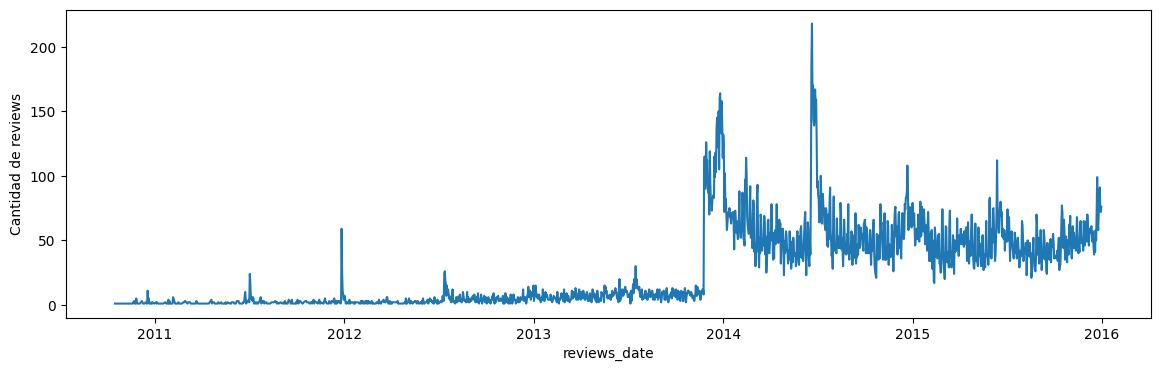

In [ ]:
# Se hace un dataframe auxiliar para analizar solo las fechas (hay campos con 'Datos no disponibles')
df = df_review[df_review["reviews_date"].str.match(r"^\d{4}-\d{2}-\d{2}$")]
# Convierte a formato fecha
df["reviews_date"] = pd.to_datetime(df["reviews_date"])
# Calcula la cantidad de review por fecha
df_counts = df.groupby("reviews_date").count()

# Grafica
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_counts, x="reviews_date", y="reviews_recommend")
plt.ylabel('Cantidad de reviews')
plt.show()

In [ ]:
print('Días de cantidad pico de reviews')
df_counts.sort_values(by='reviews_recommend', ascending=False)['reviews_recommend'][:5]

Días de cantidad pico de reviews


reviews_date
2014-06-21    218
2014-06-20    187
2014-06-23    170
2014-06-27    167
2013-12-26    164
Name: reviews_recommend, dtype: int64

Se observa que hasta cerca del 2014 la cantidad de reviews por día es bajo, con algunos picos puntuales y luego aumenta considerablemente la cantidad de comentarios con un pico máximo el 21-06-2014 con 218 comentarios en un solo día.

EDA del dataset  `df_steam_games`

En esta sección se desarrolla el Análisis Exploratorio de los Datos del archivo `df_steam_games` que ya pasó por el proceso de ETL.

Se leen los datos de .csv y se guarda en un dataframe.

In [ ]:
df_games = pd.read_csv('Datos/df_steam_games.csv', encoding='utf-8')
df_games.head()

,genres,release_date,price,early_access,id,publisher,app_name,title,developer
0,Action,2018,4.99,False,761140,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
1,Casual,2018,4.99,False,761140,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
2,Indie,2018,4.99,False,761140,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
3,Simulation,2018,4.99,False,761140,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
4,Strategy,2018,4.99,False,761140,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro


Se revisan los tipos de datos y cantidad de nulos si hay.

In [ ]:
print(f'La cantidad de registros que hay son: {df_games.shape[0]}')
def obtener_informacion_columnas(df):
    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].dtype)
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100 - porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    return df_info
informacion_columnas = obtener_informacion_columnas(df_games)
print(informacion_columnas)

La cantidad de registros que hay son: 71551
   nombre_campo tipo_datos  no_nulos_%  nulos_%  nulos
0        genres     object      100.00     0.00      0
1  release_date     object      100.00     0.00      0
2         price    float64      100.00     0.00      0
3  early_access       bool      100.00     0.00      0
4            id      int64      100.00     0.00      0
5     publisher     object       99.93     0.07     47
6      app_name     object      100.00     0.00      0
7         title     object      100.00     0.00      0
8     developer     object      100.00     0.00      0


Este conjunto de datos tiene 9 columnas y 71551 registros.  La información se repite porque un juego puede pertenecer a mas de un género.

Las columnas 'Id', 'App_name' y 'Title' hacen referencia al identificador único del juego y los nombres de la aplicación y del título del juego. Estos últimos no tienen mayor información que analizar en este momento. Con el 'id' se puede calcular la cantidad de juegos.

In [ ]:
total_juegos = len(df_games['id'].unique())
print(f"El total de juegos que hay registrados son: {total_juegos}")

El total de juegos que hay registrados son: 28850


Columna 'Genres'

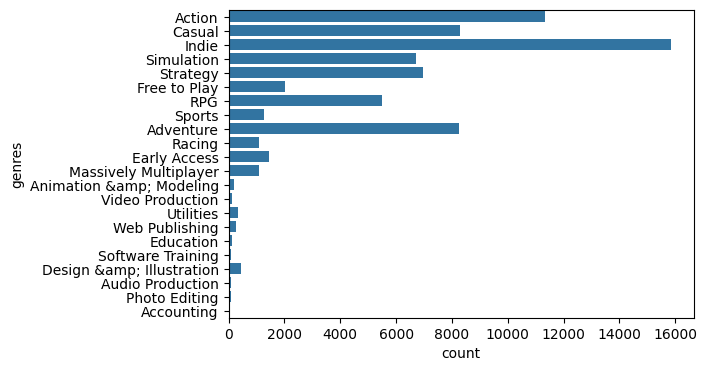

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_games, y='genres', orient='h')
plt.show()

In [ ]:
def cant_porcentaje(df, columna):
    # Cuenta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results


cant_porcentaje(df_games, 'genres')

,Cantidad,Porcentaje
genres,,
Indie,15858,22.16
Action,11319,15.82
Casual,8282,11.57
Adventure,8242,11.52
Strategy,6957,9.72
Simulation,6699,9.36
RPG,5479,7.66
Free to Play,2031,2.84
Early Access,1462,2.04


Los juegos estan categorizados mayormente en las categorías *Indi*, *Action*, *Casual* y *Adventure*.

Columna 'Release_date'

In [ ]:
def cant_porcentaje(df, columna):
    # Cuenta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results

cant_porcentaje(df_games, 'release_date')[:10]

,Cantidad,Porcentaje
release_date,,
2017,25199,35.22
2016,17693,24.73
2015,12272,17.15
2014,6367,8.90
2013,3017,4.22
2012,2107,2.94
2011,987,1.38
2010,663,0.93
2018,499,0.70


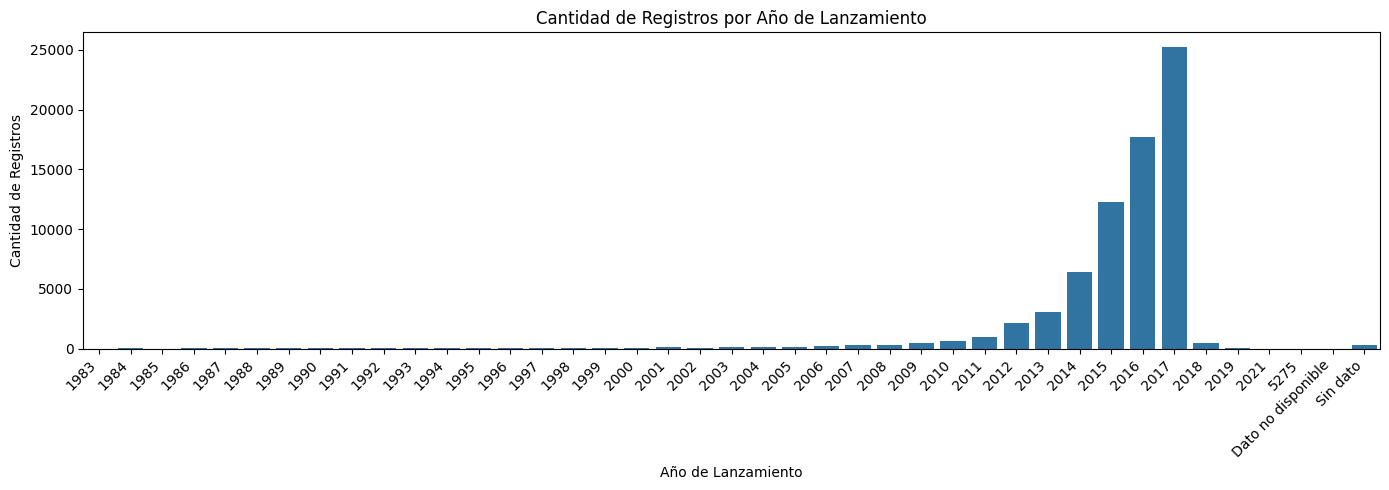

In [ ]:
# Cuenta la frecuencia de cada año
conteo_date = df_games['release_date'].value_counts()

# Ordena los valores para que 'Datos no disponibles' queden al principio o al final
conteo_date = conteo_date.reindex(['Dato no disponible'] + list(conteo_date.index))
# Ordena los valores por año
conteo_date = conteo_date.sort_index()

# Crear la gráfica de barras
plt.figure(figsize=(14, 5))
sns.barplot(x=conteo_date.index, y=conteo_date.values)
plt.xlabel('Año de Lanzamiento') ; plt.ylabel('Cantidad de Registros') ; plt.title('Cantidad de Registros por Año de Lanzamiento')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Filtra los registros con valores numéricos en la columna 'release_date'
registros_numericos = df_games[df_games['release_date'].str.isnumeric()]
# Convierte la columna 'release_date' a valores enteros
registros_numericos['release_date'] = registros_numericos['release_date'].astype(int)
# Filtra los registros con años de lanzamiento antes de 2002
registros_antes_2002 = registros_numericos[registros_numericos['release_date'] < 2002]

print(f"Cantidad de registros antes de 2002: {len(registros_antes_2002)}")

Cantidad de registros antes de 2002: 679


Se pueden ver 679 juegos lanzados en años anteriores al 2002 lo que puede ser un error porque la plataforma se lanzó en el 2003. Luego se ve el crecimiento constante y lento hasta 2012 y luego crece mas rápidamente hasta 2017. A partir de allí, la plataforma limitó la forma de obtener las estadísticas, por eso se ven muchos menos registros.

Columnas 'Publisher' y 'Developer'

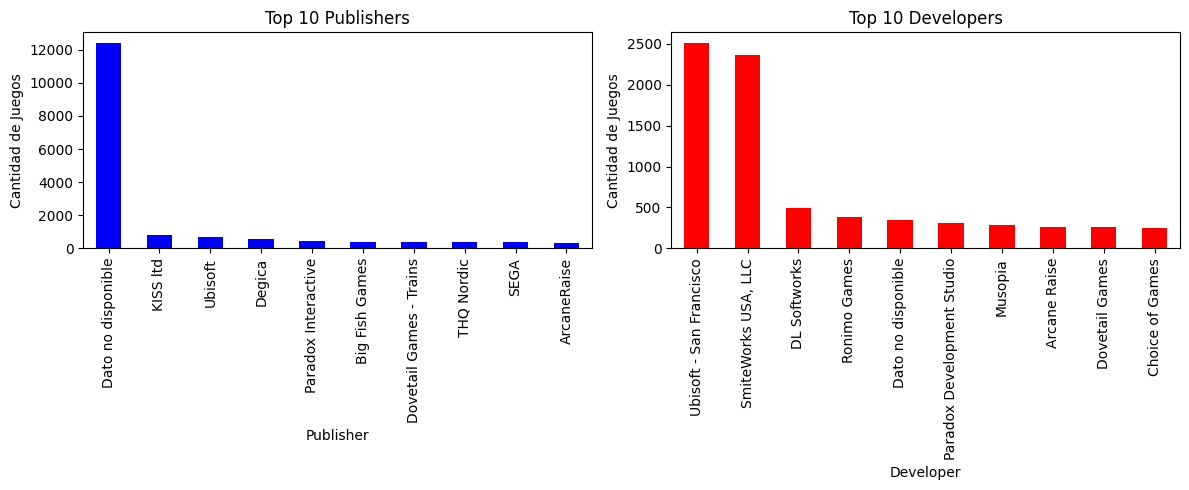

In [ ]:
# Contar la cantidad de juegos por publisher
conteo_publisher = df_games['publisher'].value_counts()

# Contar la cantidad de juegos por developer
conteo_developer = df_games['developer'].value_counts()

# Crear una figura con dos subplots uno al lado del otro
plt.figure(figsize=(12, 5))

# Primer subplot para los publishers
plt.subplot(1, 2, 1)
conteo_publisher[:10].plot(kind='bar', color='blue')
plt.xlabel('Publisher') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 10 Publishers')

# Segundo subplot para los developers
plt.subplot(1, 2, 2)
conteo_developer[:10].plot(kind='bar', color='red')
plt.xlabel('Developer') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 10 Developers')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

En el caso de los publicista de juegos, la mayor cantidad no dispone del dato y en el caso de los desarrolladores, Ubisoft y SmiteWorks son los desarrolladores que mas juegos han desarrollado para la plataforma.

Columna 'Price'

EDA del dataset  `users_items`

En esta sección se desarrolla el Análisis Exploratorio de los Datos del archivo `df_users_items`  que ya pasó por el proceso de ETL.

Se leen los datos de .csv y se guarda en un dataframe.

In [ ]:
df_items = pd.read_csv('Datos/df_user_items.csv', encoding='utf-8')
df_items.head()

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...


Se revisan los tipos de datos y cantidad de nulos si hay.

In [ ]:
print(f'La cantidad de registros que hay son: {df_items.shape[0]}')
def obtener_informacion_columnas(df):
    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].dtype)
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100 - porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    return df_info
informacion_columnas = obtener_informacion_columnas(df_items)
print(informacion_columnas)

La cantidad de registros que hay son: 5094092
       nombre_campo tipo_datos  no_nulos_%  nulos_%  nulos
0           item_id      int64       100.0      0.0      0
1         item_name     object       100.0      0.0      0
2  playtime_forever      int64       100.0      0.0      0
3          steam_id      int64       100.0      0.0      0
4       items_count      int64       100.0      0.0      0
5           user_id     object       100.0      0.0      0
6          user_url     object       100.0      0.0      0


Este conjunto de datos tiene 7 columnas y 5094092 registros. Contiene la información relacionada los usuarios y los juegos que consumen como el tiempo acumulado (en minutos) y cantidad de veces que han jugado a un juego, así como los identificadores de los juegos que consumen y del propio usuario.

Columna 'Playtime_forever'

Estas columnas hacen referencia al tiempo en minutos acumulados que un usuario ha jugado.

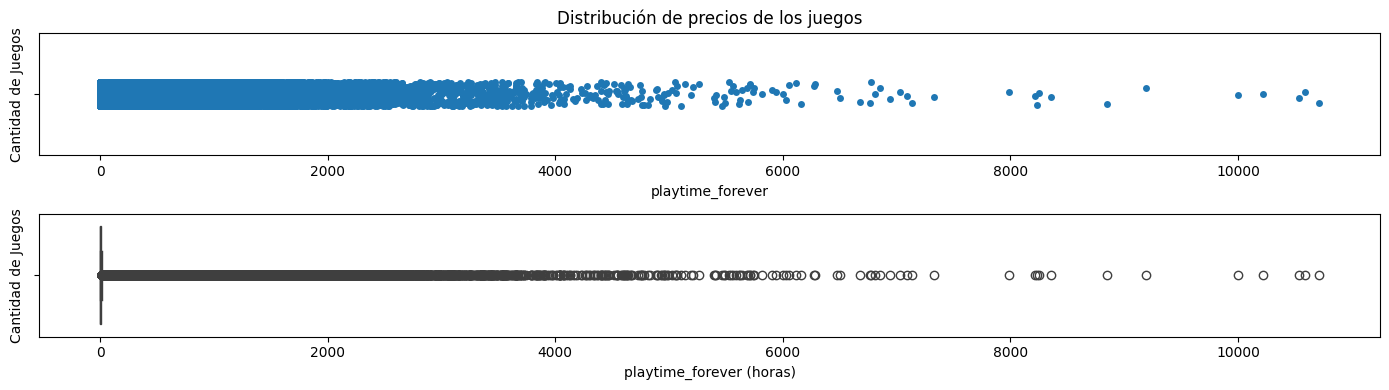

In [ ]:
df_items['playtime_hours'] = df_items['playtime_forever'] / 60

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=df_items, x='playtime_hours', ax=ax1)
ax1.set_xlabel('playtime_forever') ; ax1.set_ylabel('Cantidad de Juegos') ; ax1.set_title('Distribución de precios de los juegos')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_items, x='playtime_hours', ax=ax2)
ax2.set_xlabel('playtime_forever (horas)') ; ax2.set_ylabel('Cantidad de Juegos')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [ ]:
estadisticas = df_items['playtime_hours'].describe()
print(f'El precio medio (mediana) de los juegos es de: {round(estadisticas[5],2)}')
print(f'El precio promedio (mean) de los juegos es de: {round(estadisticas[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {round(estadisticas[6],2)}')
def bigote_sup(columna):
    # Cuartiles
    q1 = columna.describe()[4]
    q3 = columna.describe()[6]

    # Valor del vigote
    bigote_sup = round(q3 + 1.5*(q3 - q1), 2)
    print(f'El bigote superior de la variable {columna.name} se ubica en:', bigote_sup)

    # Cantidad de atípicos
    print(f'Hay {(columna > bigote_sup).sum()} valores atípicos en la variable {columna.name}')
bigote_sup(df_items['playtime_hours'])

El precio medio (mediana) de los juegos es de: 0.57
El precio promedio (mean) de los juegos es de: 16.51
El 75% de los juegos tienen un precio menor de: 5.92
El bigote superior de la variable playtime_hours se ubica en: 14.79
Hay 763595 valores atípicos en la variable playtime_hours


Se puede observar que cada usuario, por juego, pasa un tiempo medio de 0.57 hs jugando y el 75% de los jugadores estuvieron menos de 6 hs jugando a un juego, pero se observa una gran cantidad de valores atípicos por encima de las 14.79 hs que juega cada usuario a un juego. Esto podría deberse al uso de bots que utilizan el mismo perfil de usuario para jugar en simultaneo, lo que generaría una distorsión de los tiempos reales de juego.

Columna 'Items_count'

Esta columna indica la cantidad de juegos que consumen o compraron alguna vez los usuarios.

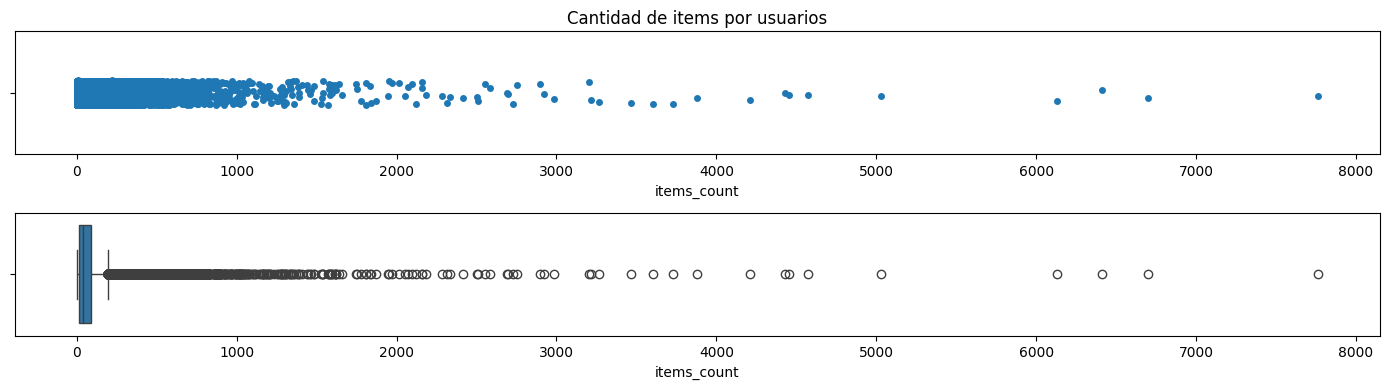

In [ ]:
# Agrupa por usuario la cantidad de items, lo conviente en data frame y los ordena de mayor a menor
items_count_user = df_items.groupby('user_id')['items_count'].unique().explode()
items_count_user = pd.DataFrame(items_count_user)
items_count_user_o = items_count_user.sort_values('items_count', ascending=False)

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=items_count_user_o, x='items_count', ax=ax1)
ax1.set_xlabel('items_count') ; ax1.set_title('Cantidad de items por usuarios')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=items_count_user_o, x='items_count', ax=ax2)
ax2.set_xlabel('items_count')

# Muestra y ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [ ]:
estadisticas = items_count_user['items_count'].astype(float).describe()
print(f'El precio medio (mediana) de los juegos es de: {round(estadisticas[5],2)}')
print(f'El precio promedio (mean) de los juegos es de: {round(estadisticas[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {round(estadisticas[6],2)}')
def bigote_sup(columna):
    # Cuartiles
    q1 = columna.describe()[4]
    q3 = columna.describe()[6]

    # Valor del vigote
    bigote_sup = round(q3 + 1.5*(q3 - q1), 2)
    print(f'El bigote superior de la variable {columna.name} se ubica en:', bigote_sup)

    # Cantidad de atípicos
    print(f'Hay {(columna > bigote_sup).sum()} valores atípicos en la variable {columna.name}')
bigote_sup(items_count_user.astype(float)['items_count'])

El precio medio (mediana) de los juegos es de: 40.0
El precio promedio (mean) de los juegos es de: 71.84
El 75% de los juegos tienen un precio menor de: 87.0
El bigote superior de la variable items_count se ubica en: 196.5
Hay 4957 valores atípicos en la variable items_count


<Figure size 1400x500 with 0 Axes>

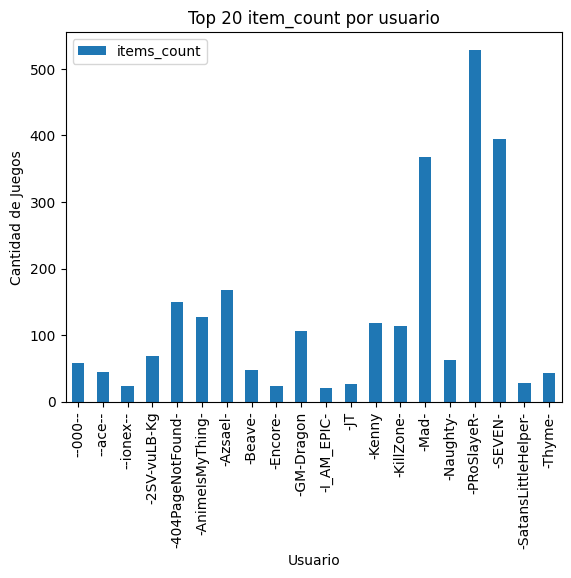

In [ ]:
# Grafica cantidad de item por usuarios
plt.figure(figsize=(14, 5))
items_count_user[:20].plot(kind='bar')
plt.xlabel('Usuario') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 20 item_count por usuario')
plt.show()

Se puede ver que el usuario que mas cantidad de juegos a consumido ronda los 8000 juegos, pero el 75% de los usuarios ha adquirido menos de 87 items. Se pueden ver 4957 usuarios que hay adquirido mas de 196 items que podrían considerarse como atípicos.

## Para el modelo de recomendación se busca como resultado la recomendación un una lista de 5 juegos a partir de indicar el nombre de un juego o el id de un usuario, basado en un puntaje que se debe decidir cómo crearlo. Para ello, se revisan los dataframe df_reviews y df_items analizados anteriormente.

In [ ]:
df_reviews = pd.read_csv('Datos/df_user_reviews.csv', encoding='utf-8')
df_items = pd.read_csv('Datos/df_user_items.csv', encoding='utf-8')

In [ ]:
df_reviews.head(2)

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_review,reviews_date,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,2011-11-05,1
1,js41637,http://steamcommunity.com/id/js41637,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,2014-06-24,1


In [ ]:
df_items.head(2)

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...


Con los datos disponible, se decide crear un puntaje (rating) para los juegos a partir de considerar el análisis de sentimiento de las reviews para cada juego y las recomendaciones del usuario para ese juego. Recordar que el análisis de sentimiento esta calificado como 0 (sentimiento negativo), 1 (sentimiento neutral) y 2 (sentimiento positivo) y las recomendaciones al juego son True (cuando lo recomienda) y False (cuando no recomienda el juego). Con esta información se busca hacer un puntaje del 1 al 5, siendo el 1 un juego no recomendado que cuentan con reviews con sentimientos negativos y 5 un juego recomendado y con reviews positivos. Se considera esta escala en función de la combinación de las dos variables de esta manera:

* **1** si el análisis de sentimiento es negativo ya sea que este recomendado o no (True o False)
* **2** si el análisis de sentimiento es neutral y no es recomendado (False)
* **3** si el análisis de sentimiento es neutral pero es recomendado (True)
* **4** si el análisis de sentimiento es positivo y no es recomendado (False)
* **5** si el análisis de sentimiento es positivo y es recomendado (True)

Con esto, se arma la siguiente función:

In [ ]:
def calcula_rating(row):
    if row["sentiment_analysis"] == 0 and not row["reviews_recommend"]:
        return 1
    elif row["sentiment_analysis"] == 0 and row["reviews_recommend"]:
        return 1
    elif row["sentiment_analysis"] == 1 and not row["reviews_recommend"]:
        return 2
    elif row["sentiment_analysis"] == 1 and row["reviews_recommend"]:
        return 3
    elif row["sentiment_analysis"] == 2 and not row["reviews_recommend"]:
        return 4
    elif row["sentiment_analysis"] == 2 and row["reviews_recommend"]:
        return 5
    else:
        return None

Se aplica esta función en una nueva columna sobre el dataframe `df_reviews`

In [ ]:
df_reviews['rating'] = df_reviews.apply(calcula_rating, axis=1)
df_reviews.head(2)

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_review,reviews_date,sentiment_analysis,rating
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,2011-11-05,1,3
1,js41637,http://steamcommunity.com/id/js41637,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,2014-06-24,1,3


Se crea un nuevo dataframe dejando solo las columnas 'user_id', 'reviews_item_id' y 'rating' y se reserva.

In [ ]:
df1 = df_reviews[['user_id', 'reviews_item_id', 'rating']]
df1.head(2)

,user_id,reviews_item_id,rating
0,76561197970982479,1250,3
1,js41637,251610,3


Se crea otro datafrma que contenga unicamente los 'item_id' y los nombres de los juego.

In [ ]:
df2 = df_items[['item_id', 'item_name']]
# Se borran los dumplicados
df2 = df2.drop_duplicates()
# Cantidad de juegos
print(f'Hay un total de {len(df2)} juegos')
df2.head(2)

Hay un total de 10978 juegos


,item_id,item_name
0,10,Counter-Strike
1,20,Team Fortress Classic


Luego se agregan los nombres de los juegos al primer dataframe.

In [ ]:
df = df1.merge(df2, left_on="reviews_item_id", right_on="item_id", how='left')
df

,user_id,reviews_item_id,rating,item_id,item_name
0,76561197970982479,1250,3,1250.0,Killing Floor
1,js41637,251610,3,251610.0,Barbie™ Dreamhouse Party™
2,evcentric,248820,5,248820.0,Risk of Rain
3,doctr,250320,5,250320.0,The Wolf Among Us
4,maplemage,211420,3,211420.0,Dark Souls: Prepare to Die Edition
...,...,...,...,...,...
57362,How51,440,3,NaN,NaN
57363,76561198111410893,304930,3,304930.0,Unturned
57364,zaza147,265630,5,265630.0,Fistful of Frags
57365,lifeonhigh,304050,3,304050.0,Trove


Se pueden observar algunos juegos a los cuales los usuarios les hicieron comentarios, pero que no estan en el dataframe `df_reviews`. Se verifican los tipos de datos y la cantidad de nulos y luego se revisan las filas con nulos.

In [ ]:
def obtener_informacion_columnas(df):
    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].dtype)
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100 - porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    return df_info
informacion_columnas = obtener_informacion_columnas(df_reviews)
print(informacion_columnas)



         nombre_campo tipo_datos  no_nulos_%  nulos_%  nulos
0             user_id     object       100.0      0.0      0
1            user_url     object       100.0      0.0      0
2     reviews_item_id      int64       100.0      0.0      0
3     reviews_helpful     object       100.0      0.0      0
4   reviews_recommend       bool       100.0      0.0      0
5      reviews_review     object       100.0      0.0      0
6        reviews_date     object       100.0      0.0      0
7  sentiment_analysis      int64       100.0      0.0      0
8              rating      int64       100.0      0.0      0


In [ ]:
# se revisan los reviews sin nombres de juegos en `df_items`
sin_juegos = df[df.isnull().any(axis=1)]
# Se calculan la cantidad de juegos en esta situación
print(f"Hay un total de {len(sin_juegos['reviews_item_id'].unique())} juegos con reviews pero que no estan en `df_reviews`")
sin_juegos

Hay un total de 354 juegos con reviews pero que no estan en `df_reviews`


,user_id,reviews_item_id,rating,item_id,item_name
10,76561198077246154,440,3,NaN,NaN
19,devvonst,440,5,NaN,NaN
28,76561198076909484,570,1,NaN,NaN
36,boydeer,440,3,NaN,NaN
43,jarrodtrim,440,5,NaN,NaN
...,...,...,...,...,...
57323,ViniReaper,440,5,NaN,NaN
57346,BlinkV1,440,3,NaN,NaN
57353,76561198095035915,440,1,NaN,NaN
57362,How51,440,3,NaN,NaN


Se decide borrarlos del conjunto de datos.

In [ ]:
# Se borran los nulos
df = df.dropna(subset=['item_id'])
# Se cuentan los registros que quedan
print(f'Quedan {df.shape[0]} registros')
# Se verifican los tipo de dato y nulos
def obtener_informacion_columnas(df):
    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].dtype)
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100 - porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    return df_info
informacion_columnas = obtener_informacion_columnas(df_reviews)
print(informacion_columnas)


Quedan 51039 registros
         nombre_campo tipo_datos  no_nulos_%  nulos_%  nulos
0             user_id     object       100.0      0.0      0
1            user_url     object       100.0      0.0      0
2     reviews_item_id      int64       100.0      0.0      0
3     reviews_helpful     object       100.0      0.0      0
4   reviews_recommend       bool       100.0      0.0      0
5      reviews_review     object       100.0      0.0      0
6        reviews_date     object       100.0      0.0      0
7  sentiment_analysis      int64       100.0      0.0      0
8              rating      int64       100.0      0.0      0


Se convierte en entero la columna 'item_id' y se crea un último dataframe con las columnas necesarias para los modelos de recomendación.

In [ ]:
df = df[['user_id', 'item_name', 'rating']]
df.head(3)

,user_id,item_name,rating
0,76561197970982479,Killing Floor,3
1,js41637,Barbie™ Dreamhouse Party™,3
2,evcentric,Risk of Rain,5


En el siguiente gráfico se pueden ver la cantidad de reviews distribuidos por el puntaje adoptado.

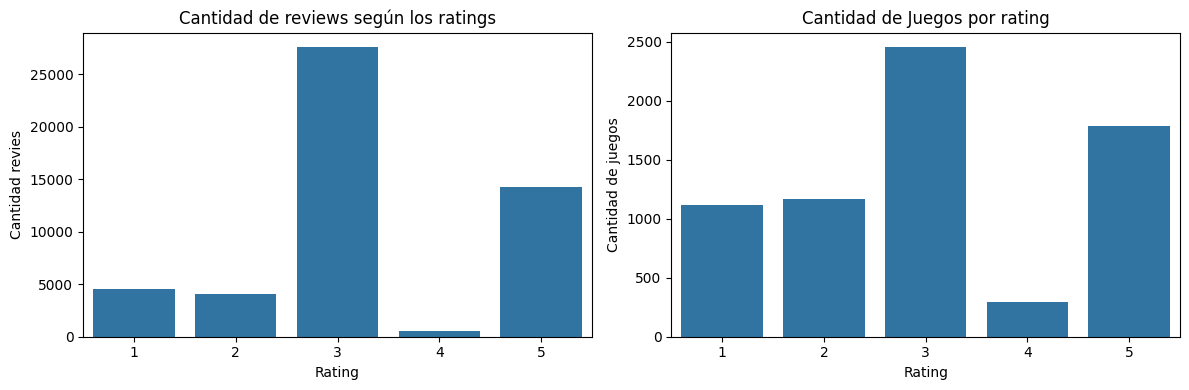

In [ ]:
# Agrupa las calificaciones por rating
ratings_count = df['rating'].value_counts().reset_index()
ratings_count.columns = ['rating', 'count']
# Agrupa los juegos únicos por rating
unique_games_per_rating = df.groupby('rating')['item_name'].nunique().reset_index()

# Crea una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Primer subplot
sns.barplot(data=ratings_count, x='rating', y='count', ax=axes[0])
axes[0].set_title('Cantidad de reviews según los ratings') ; axes[0].set_xlabel('Rating') ; axes[0].set_ylabel('Cantidad revies')

# Segundo subplot
sns.barplot(data=unique_games_per_rating, x='rating', y='item_name', ax=axes[1])
axes[1].set_title('Cantidad de Juegos por rating') ; axes[1].set_xlabel('Rating') ; axes[1].set_ylabel('Cantidad de juegos')

# Ajusta y muestra los graficos
plt.tight_layout()
plt.show()

In [ ]:
# Cantidades de review por rating
def cant_porcentaje(df, columna):
    # Cuanta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results
cant_porcentaje(df, 'rating')

,Cantidad,Porcentaje
rating,,
3,27561,54.00
5,14237,27.89
1,4585,8.98
2,4103,8.04
4,553,1.08


In [ ]:
# Cantidades de juegos por rating
unique_games_per_rating

,rating,item_name
0,1,1114
1,2,1168
2,3,2451
3,4,292
4,5,1788


Se puede ver en la gráfica de la derecha que la mayoría de las reviews tienen un 'rating' de 3, correspondiente a sentimientos neutrales pero que recomiendan el juego, siendo 27581 reviews (el 54% de los comentarios) en esta categoría. Le siguen 14237 reviews con sentimientos positivos y que recomiendan los juegos comentados. Finalmente, se observan menos de 6000 comentarios con sentimiento negativo. Por otro lado, en la gráfica de la izquierda se pueden observa cerca de 1800 juegos recomendados.

Finalmente, se guarda el dataframe a utilizar en el modelo de recomnedación.

In [ ]:
df.to_csv('Datos/df_recomendacion.csv', index=False, encoding='utf-8')